In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn, relu
from torchvision import datasets, transforms
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from time import time
from model import pPCA, DeepNonLinearVAEForPosteriorCollapse

In [2]:
class config:
    latent_dim = 200
    data_size = 1000
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    epsilon_list = np.linspace(0, 2, 100)
    delta = 0.01
    sigma_sq_list = [30.0,10.0,3.0,1.0,0.3,0.1,0.03,0.02,0.01,0.003,0.001,0.0001]
print(config.device)
print(len(config.sigma_sq_list))
def seed_torch(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)

cuda:0
12


In [3]:
seed_torch(0)
latent_dim = config.latent_dim
data_size = config.data_size
device = config.device
delta = config.delta
epsilon_list = config.epsilon_list
sigma_sq_list = config.sigma_sq_list

In [4]:
mnist_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
]))

In [5]:
def preprocess(x, eps):
    x = (x + np.random.rand(*x.shape)) / 256.0
    x = eps + (1 - 2 * eps) * x
    x = np.log(x / (1.0 - x))
    x = x.to(torch.float32)
    return x

def calculate_posterior_collapse(mu, std, epsilon_list, delta):
    all_kl = 0.5 * (mu ** 2 + std ** 2 - 1.0 - torch.log(std ** 2))
    threshold = 1.0 - delta
    each_epsilon_result = []
    for epsilon in epsilon_list:
        if_posterior_collapse = (all_kl < epsilon) + 0.0
        posterior_collapse_probability_for_each_dim = torch.mean(if_posterior_collapse, dim=0)
        percentage_posterior_collapse = ((posterior_collapse_probability_for_each_dim > threshold) + 0.0).mean()
        each_epsilon_result.append(percentage_posterior_collapse.detach().cpu().numpy())
    return each_epsilon_result

loader = mnist_data.data[:data_size].view(-1, 784)
loader = preprocess(loader, 1e-6)
loader_numpy = loader.numpy()
loader = loader.to(device)
pcaModel = pPCA(loader_numpy, latent_dim)
W_mle, sigma_mle, loglikelihood = pcaModel.get_result()

In [6]:
# Trainable sigma
trainable_final_elbo_dict={}
trainable_final_sigma_dict={}
trainable_posterior_collapse_dict={}
for sigma_sq in sigma_sq_list:
    log_sigma_sq = np.log(sigma_sq)
    model = DeepNonLinearVAEForPosteriorCollapse(784, latent_dim, 784, log_sigma_sq, True).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    for i in range(20000):
        elbo, final_log_sigma_sq, mu, std = model(loader)
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        if i == 999:
            trainable_final_elbo_dict[str(sigma_sq)]=-elbo.detach().cpu().numpy()
            trainable_final_sigma_dict[str(sigma_sq)]=np.exp(final_log_sigma_sq.detach().cpu().numpy())

            result = calculate_posterior_collapse(mu, std, epsilon_list, delta)
            trainable_posterior_collapse_dict[str(sigma_sq)]=result
            print("Finished:{}".format(sigma_sq))

Finished:30.0
Finished:10.0
Finished:3.0
Finished:1.0
Finished:0.3
Finished:0.1
Finished:0.03
Finished:0.02
Finished:0.01
Finished:0.003
Finished:0.001
Finished:0.0001


In [7]:
# Non-Trainable sigma
nontrainable_final_elbo_dict={}
nontrainable_posterior_collapse_dict={}
for sigma_sq in sigma_sq_list:
    log_sigma_sq = np.log(sigma_sq)
    model = DeepNonLinearVAEForPosteriorCollapse(784, latent_dim, 784, log_sigma_sq, False).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    for i in range(20000):
        elbo, final_log_sigma_sq, mu, std = model(loader)
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        if i == 999:
            nontrainable_final_elbo_dict[str(sigma_sq)]=-elbo.detach().cpu().numpy()
            result = calculate_posterior_collapse(mu, std, epsilon_list, delta)
            nontrainable_posterior_collapse_dict[str(sigma_sq)]=result
            print("Finished:{}".format(sigma_sq))

Finished:30.0
Finished:10.0
Finished:3.0
Finished:1.0
Finished:0.3
Finished:0.1
Finished:0.03
Finished:0.02
Finished:0.01
Finished:0.003
Finished:0.001
Finished:0.0001


<Figure size 800x550 with 0 Axes>

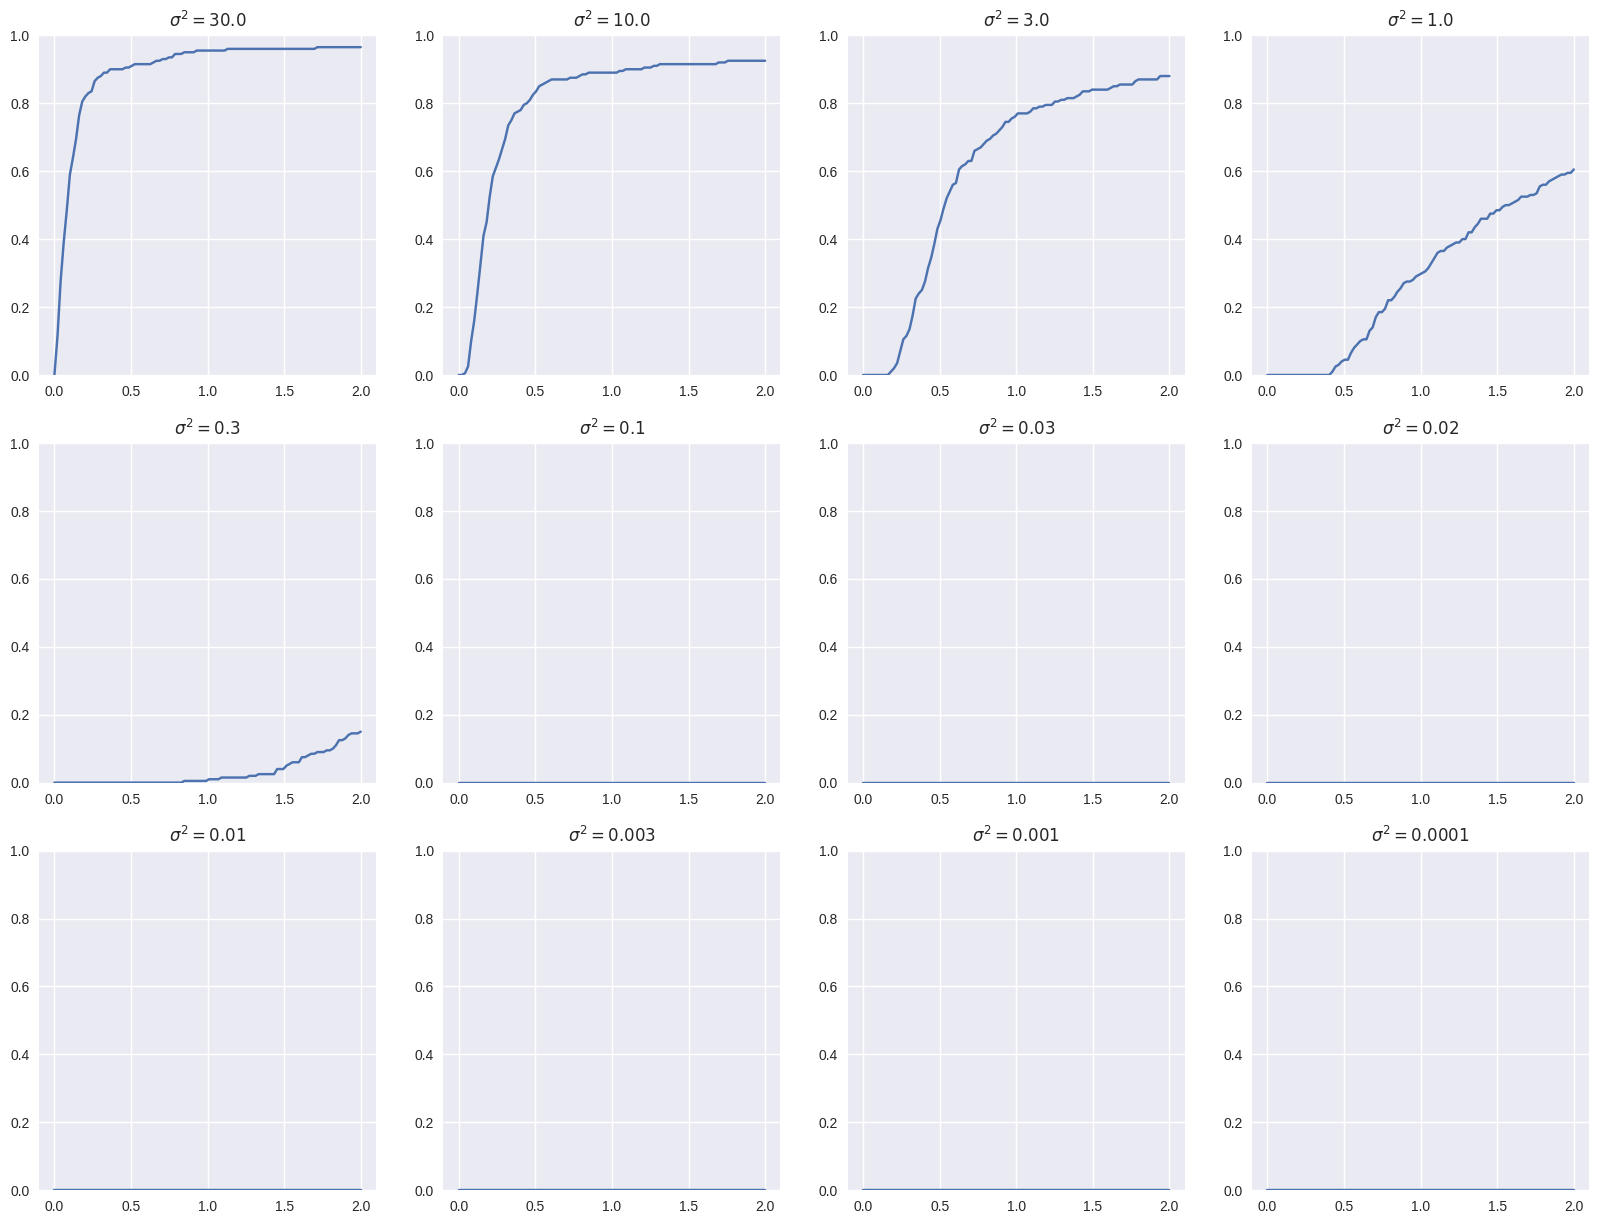

In [52]:
subplots_adjust(left=0,bottom=0,top=2,right=2)
# plt.suptitle('Various Straight Lines',fontsize=20)
plt.figure(figsize=(20, 15))
for i in range(1,13):
    plt.subplot(3, 4, i)
    plt.plot(epsilon_list,trainable_posterior_collapse_dict[str(sigma_sq_list[i-1])])
    plt.title("$\sigma^2={}$".format(sigma_sq_list[i-1]))
    plt.ylim(0,1)
# plt.tight_layout()#调整整体空白
# plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
plt.style.use("seaborn")
plt.savefig("Posterior_collapse_learnable_variance.jpg",dpi=500)
plt.show()

<Figure size 800x550 with 0 Axes>

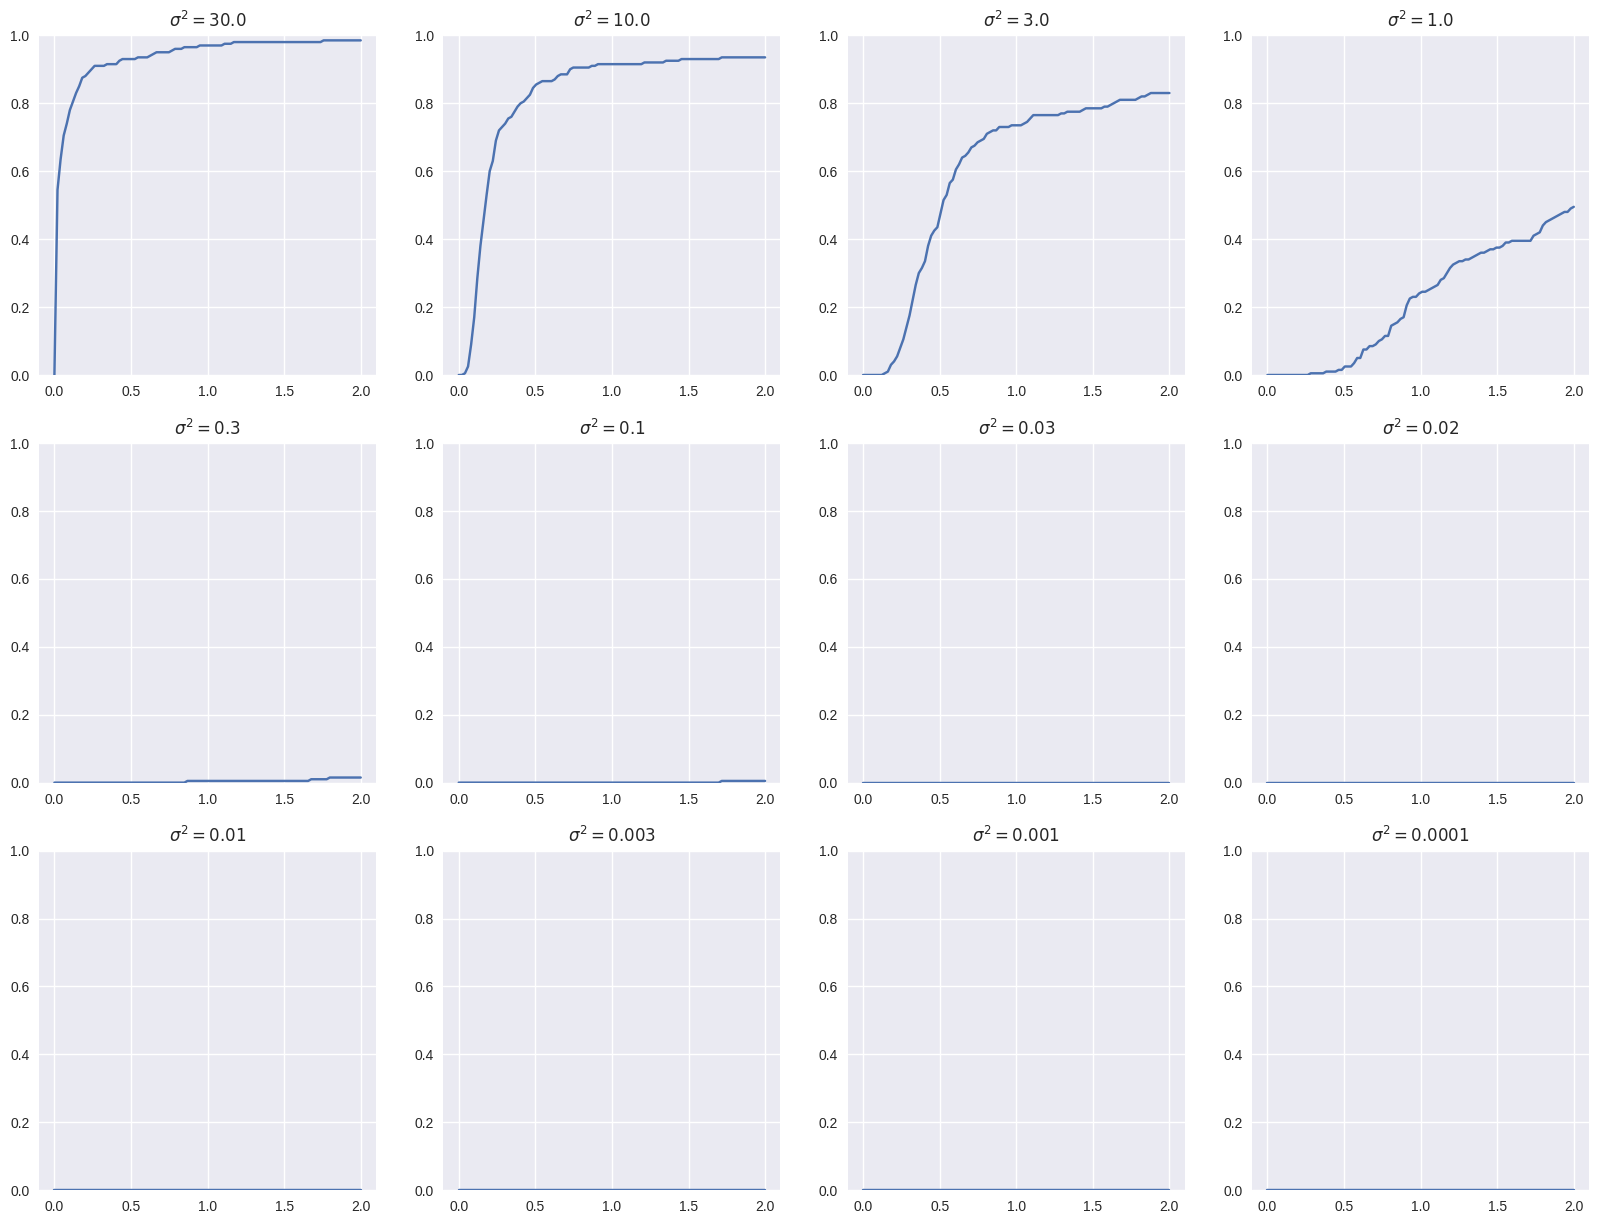

In [53]:
subplots_adjust(left=0,bottom=0,top=2,right=2)
# plt.suptitle('Various Straight Lines',fontsize=20)
plt.figure(figsize=(20, 15))
for i in range(1,13):
    plt.subplot(3, 4, i)
    plt.plot(epsilon_list,nontrainable_posterior_collapse_dict[str(sigma_sq_list[i-1])])
    plt.title("$\sigma^2={}$".format(sigma_sq_list[i-1]))
    plt.ylim(0,1)
# plt.tight_layout()#调整整体空白
# plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
plt.style.use("seaborn")
plt.savefig("Posterior_collapse_nonlearnable_variance.jpg",dpi=500)
plt.show()

In [12]:
import pandas as pd
# Trainable result
pd.set_option('display.float_format',lambda x : '%.8f' % x)
train_comb = [trainable_final_elbo_dict,trainable_final_sigma_dict]
df = pd.DataFrame(train_comb,index=['ELBO','final sigma']).T
df


,ELBO,final sigma
30.0,-1972.81652832,18.09906031
10.0,-1631.82336426,6.36799752
3.0,-1487.44653320,3.11769648
1.0,-1477.56677246,1.18655485
0.3,-2268.32031250,0.37338444
0.1,-4449.24658203,0.12350191
0.03,-27298.73632812,0.03739700
0.02,-21164.50976562,0.02480147
0.01,-67350.89062500,0.01289818
0.003,-169663.64062500,0.00376452


In [13]:
import pandas as pd
# nonTrainable result


pd.set_option('display.float_format',lambda x : '%.8f' % x)
train_comb = [nontrainable_final_elbo_dict]
df = pd.DataFrame(train_comb,index=['ELBO']).T
df

,ELBO
30.0,-2134.81274414
10.0,-1763.62438965
3.0,-1481.37011719
1.0,-1497.06762695
0.3,-2346.36108398
0.1,-7620.07714844
0.03,-37784.11328125
0.02,-46748.40234375
0.01,-174601.90625000
0.003,-399478.62500000
